# Advanced quantitative techniques - Class 2 - OLS, Logit, and Multinomial models

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import scipy as sp

## 1. Review of the OLS model

In [2]:
# Importing and preparing the data
# slide 5
gss = pd.read_csv("Data/trends-gss.csv")
variables = ['happy', 'realinc', 'year']
d = gss[variables].copy()

d['rhappy'] = 4 - d.happy
d['inc10k'] = d.realinc/10000
d['loginc'] = np.log(d.realinc)

In [3]:
# the simplest regression 
from statsmodels.regression.linear_model import OLS

lm1 = OLS.from_formula('rhappy ~ inc10k', data=d).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rhappy   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1413.
Date:                Fri, 04 Jan 2019   Prob (F-statistic):          1.16e-304
Time:                        21:10:13   Log-Likelihood:                -44675.
No. Observations:               47120   AIC:                         8.935e+04
Df Residuals:                   47118   BIC:                         8.937e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0715      0.004    484.720      0.000       2.063       2.080
inc10k         0.0381      0.001     37.587      0.000       0.036       0.040
==============================================================================
Omnibus:                     1784.423   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              911.385
Skew:                          -0.152   Prob(JB):                    1.25e-198
Kurtosis:                       2.390   Cond. No.                         6.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Testing for heteroskedasticity

In [4]:
# slide 13
from statsmodels.stats.diagnostic import het_breuschpagan

name = ['BP', 'p-value', 'f-value', 'f p-value']

test = het_breuschpagan(lm1.resid, lm1.model.exog)
lzip(name, test)

[('BP', 133.47399902855602),
 ('p-value', 7.12092031508595e-31),
 ('f-value', 133.84747546770265),
 ('f p-value', 6.496153223033921e-31)]

### Correcting for heteroskedasticity
To apply robust (Huber-White, sandwich) standard error, specify `cov_type = 'HC1'` when fitting the model

In [5]:
OLS.from_formula('rhappy ~ inc10k', data=d).fit(cov_type = 'HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rhappy   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1445.
Date:                Fri, 04 Jan 2019   Prob (F-statistic):          1.90e-311
Time:                        21:10:20   Log-Likelihood:                -44675.
No. Observations:               47120   AIC:                         8.935e+04
Df Residuals:                   47118   BIC:                         8.937e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0715      0.004    472.973      0.000       2.063       2.080
inc10k         0.0381      0.001     38.012      0.000       0.036       0.040
==============================================================================
Omnibus:                     1784.423   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              911.385
Skew:                          -0.152   Prob(JB):                    1.25e-198
Kurtosis:                       2.390   Cond. No.                         6.45
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### A slightly more complex regression

In [6]:
lm2 = OLS.from_formula('rhappy ~ loginc', data=d).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rhappy   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1838.
Date:                Fri, 04 Jan 2019   Prob (F-statistic):               0.00
Time:                        21:10:25   Log-Likelihood:                -44469.
No. Observations:               47120   AIC:                         8.894e+04
Df Residuals:                   47118   BIC:                         8.896e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9675      0.029     33.752      0.000       0.911       1.024
loginc         0.1230      0.003     42.872      0.000       0.117       0.129
==============================================================================
Omnibus:                     1666.278   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              847.342
Skew:                          -0.134   Prob(JB):                    1.00e-184
Kurtosis:                       2.400   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2. Review of the Logit model

### First, a simple OLS model

In [7]:
# slide 20
# Unlike R, Python doesn't automatically ignore NA's, so we have to first take care of the case with NA
d['very'] = np.where(pd.isnull(d.rhappy), np.nan, 
                    np.where(d.rhappy>2, 1, 0))

lm3 = OLS.from_formula('very ~ inc10k', data=d).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   very   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     884.2
Date:                Fri, 04 Jan 2019   Prob (F-statistic):          1.62e-192
Time:                        21:10:32   Log-Likelihood:                -30256.
No. Observations:               47120   AIC:                         6.052e+04
Df Residuals:                   47118   BIC:                         6.053e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2449      0.003     77.816      0.000       0.239       0.251
inc10k         0.0222      0.001     29.735      0.000       0.021       0.024
==============================================================================
Omnibus:                   166672.986   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8106.925
Skew:                           0.783   Prob(JB):                         0.00
Kurtosis:                       1.704   Cond. No.                         6.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### A simple logit

In [8]:
# slide 22
ll = smf.glm('very ~ inc10k', data=d, family=sm.families.Binomial()).fit()
ll.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   very   No. Observations:                47120
Model:                            GLM   Df Residuals:                    47118
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28910.
Date:                Fri, 04 Jan 2019   Deviance:                       57820.
Time:                        21:10:36   Pearson chi2:                 4.70e+04
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0956      0.015    -72.883      0.000      -1.125      -1.066
inc10k         0.0973      0.003     28.797      0.000       0.091       0.104
==============================================================================
"""

In [17]:
# slide 25
# interpreting the logistic regression parameters
np.exp(ll.params)

Intercept    0.334331
inc10k       1.102244
dtype: float64

## 3. The ordinal logit

At the time of this writing, there is no robust statistical tools to perform ordinal logistic regression in Python. However, we do have the option of calling R functions within ipython notebook. This can be achieved with the `rpy2` module.

First we load the package `ordinal` from R and the necessary extension. Note that `ordinal` must be installed in R in order for this to work. You might also need to install the Python version of the R package in your virtual environment. For example, the `ordinal` package for Python can be installed with the command `conda install -c conda-forge r-ordinal`.

In [9]:
from rpy2.robjects.packages import importr

ordinal = importr('ordinal')

%load_ext rpy2.ipython

In [10]:
# create new dataframe with missing values dropped
d_noNA = d.dropna()

`%%` means that the entire cell will be evaluated in R mode. `-i` is to import existing variable in the environment. Here we are importing our existing Pandas dataframe `d_noNA`. 

In [11]:
%%R -i d_noNA

fm1 = clm(as.factor(rhappy) ~ inc10k, data=d_noNA)
summary(fm1)

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


formula: as.factor(rhappy) ~ inc10k
data:    d_noNA

 link  threshold nobs  logLik    AIC      niter max.grad cond.H 
 logit flexible  47120 -43918.69 87843.37 6(0)  6.25e-12 8.5e+01

Coefficients:
       Estimate Std. Error z value Pr(>|z|)    
inc10k  0.11633    0.00325    35.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Threshold coefficients:
    Estimate Std. Error z value
1|2 -1.62773    0.01652  -98.52
2|3  1.16450    0.01480   78.70


In [71]:
%%R 
exp(coef(fm1))

     1|2      2|3   inc10k 
0.196374 3.204331 1.123370 


In [54]:
# slide 35
%%R -i d_noNA

fm2 = clm(as.factor(rhappy) ~ 1, nominal=~inc10k, data=d_noNA)
summary(fm2)

formula: as.factor(rhappy) ~ 1
nominal: ~inc10k
data:    d_noNA

 link  threshold nobs  logLik    AIC      niter max.grad cond.H 
 logit flexible  47120 -43779.71 87567.43 7(0)  1.27e-10 1.1e+02

Threshold coefficients:
                 Estimate Std. Error z value
1|2.(Intercept) -1.389929   0.021824  -63.69
2|3.(Intercept)  1.101608   0.015141   72.76
1|2.inc10k      -0.220927   0.007744  -28.53
2|3.inc10k      -0.099330   0.003424  -29.01


In [72]:
%%R 
exp(coef(fm2))

1|2.(Intercept) 2|3.(Intercept)      1|2.inc10k      2|3.inc10k 
      0.2490929       3.0090014       0.8017752       0.9054435 


In [73]:
# slide 37
%%R
anova(fm1, fm2)

Likelihood ratio tests of cumulative link models:
 
    formula:                   nominal: link: threshold:
fm1 as.factor(rhappy) ~ inc10k ~1       logit flexible  
fm2 as.factor(rhappy) ~ 1      ~inc10k  logit flexible  

    no.par   AIC logLik LR.stat df Pr(>Chisq)    
fm1      3 87843 -43919                          
fm2      4 87567 -43780  277.94  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## 4. Multinomial logit regression

In [23]:
# Make '2.0' the reference level for 'rhappy'

d['rhappy'] = d['rhappy'].astype('category')
d['rhappy'].cat.reorder_categories([2, 1, 3], inplace=True)

In [34]:
from statsmodels.discrete.discrete_model import MNLogit

ml1 = MNLogit.from_formula('rhappy ~ 1 + inc10k', data=d).fit()
ml1.summary()

Optimization terminated successfully.
         Current function value: 0.928690
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                47120
Model:                        MNLogit   Df Residuals:                    47116
Method:                           MLE   Df Model:                            2
Date:                Fri, 04 Jan 2019   Pseudo R-squ.:                 0.01847
Time:                        21:50:41   Log-Likelihood:                -43760.
converged:                       True   LL-Null:                       -44583.
                                        LLR p-value:                     0.000
===============================================================================
y=rhappy[1]       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.0002      0.023    -43.428      0.000      -1.045      -0.955
inc10k         -0.2068      0.008    -25.203      0.000      -0.223      -0.191
-------------------------------------------------------------------------------
y=rhappy[3]       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.8293      0.016    -53.377      0.000      -0.860      -0.799
inc10k          0.0742      0.003     21.614      0.000       0.067       0.081
===============================================================================
"""

In [31]:
# slide 45
sp.stats.chi2.pdf(222.1808, 1)

1.51917949635592e-50

In [32]:
# slide 47
np.exp(ml1.params)

,0,1
Intercept,0.367792,0.436367
inc10k,0.813160,1.077048


In [33]:
# slide 55

ml2 = MNLogit.from_formula('rhappy ~ 1 + loginc', data=d).fit()
ml2.summary()

Optimization terminated successfully.
         Current function value: 0.926534
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                47120
Model:                        MNLogit   Df Residuals:                    47116
Method:                           MLE   Df Model:                            2
Date:                Fri, 04 Jan 2019   Pseudo R-squ.:                 0.02075
Time:                        21:50:32   Log-Likelihood:                -43658.
converged:                       True   LL-Null:                       -44583.
                                        LLR p-value:                     0.000
===============================================================================
y=rhappy[1]       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.3599      0.128     18.402      0.000       2.109       2.611
loginc         -0.3986      0.013    -30.019      0.000      -0.425      -0.373
-------------------------------------------------------------------------------
y=rhappy[3]       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.1056      0.114    -27.131      0.000      -3.330      -2.881
loginc          0.2513      0.011     22.214      0.000       0.229       0.273
===============================================================================
"""

## 5. Interaction with the logit model

In [36]:
# slide 68
GSS_2010 = gss[gss.year==2010].copy()
GSS_2010.colhomo.value_counts()

4.0    1064
5.0     191
Name: colhomo, dtype: int64

In [37]:
GSS_2010['n_colhomo'] = np.where(pd.isnull(GSS_2010.colhomo), np.nan, 
                                np.where(GSS_2010.colhomo==5, 1, 0))

GSS_2010['n_fund'] = GSS_2010.fund.map({1: 'Fundamentalist', 2: 'moderate', 3: 'liberal'})
GSS_2010['n_fund'] = GSS_2010.n_fund.astype('category')

In [38]:
# slide 70
logit_colhomo = smf.glm('n_colhomo ~ fund + educ + age', data=GSS_2010, family=sm.families.Binomial()).fit()

logit_colhomo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              n_colhomo   No. Observations:                 1193
Model:                            GLM   Df Residuals:                     1189
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -448.76
Date:                Fri, 04 Jan 2019   Deviance:                       897.51
Time:                        22:01:41   Pearson chi2:                 1.17e+03
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2594      0.482      0.538      0.591      -0.686       1.205
fund          -0.5388      0.115     -4.699      0.000      -0.764      -0.314
educ          -0.1652      0.028     -5.905      0.000      -0.220      -0.110
age            0.0234      0.005      4.760      0.000       0.014       0.033
==============================================================================
"""

In [39]:
# slide 73
logit_colhomo2 = smf.glm('n_colhomo ~ n_fund*educ + age', data=GSS_2010, family=sm.families.Binomial()).fit()
logit_colhomo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              n_colhomo   No. Observations:                 1193
Model:                            GLM   Df Residuals:                     1186
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -439.29
Date:                Fri, 04 Jan 2019   Deviance:                       878.57
Time:                        22:01:45   Pearson chi2:                 1.26e+03
No. Iterations:                     6   Covariance Type:             nonrobust
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.6006      0.700     -0.858      0.391      -1.972       0.771
n_fund[T.liberal]           1.8766      1.046      1.794      0.073      -0.174       3.927
n_fund[T.moderate]         -1.3704      0.826     -1.659      0.097      -2.989       0.249
educ                       -0.1318      0.049     -2.672      0.008      -0.229      -0.035
n_fund[T.liberal]:educ     -0.2245      0.083     -2.712      0.007      -0.387      -0.062
n_fund[T.moderate]:educ     0.0332      0.065      0.511      0.609      -0.094       0.160
age                         0.0242      0.005      4.817      0.000       0.014       0.034
===========================================================================================
"""

In [61]:
logit_colhomo2_df = pd.DataFrame(np.arange(21), columns=['educ'])

In [62]:
logit_colhomo2_df['fundamentalist'] = 1 + logit_colhomo2.params[0] + logit_colhomo2_df.educ*logit_colhomo2.params[3]
logit_colhomo2_df['moderate'] = 1 + logit_colhomo2.params[0] + logit_colhomo2.params[2] + \
                                logit_colhomo2_df.educ*logit_colhomo2.params[3] + logit_colhomo2_df.educ*logit_colhomo2.params[5]
logit_colhomo2_df['liberal'] = 1 + logit_colhomo2.params[0] + logit_colhomo2.params[1] + \
                                logit_colhomo2_df.educ*logit_colhomo2.params[3] + logit_colhomo2_df.educ*logit_colhomo2.params[4]

([<matplotlib.axis.XTick at 0x1c334d6828>,
 <a list of 5 Text xticklabel objects>)

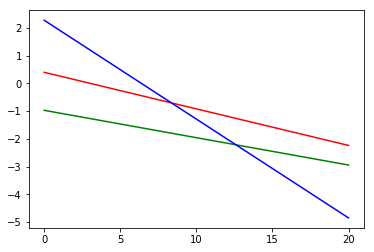

In [63]:
logit_colhomo2_df['fundamentalist'].plot(color='r')
logit_colhomo2_df['moderate'].plot(color='g')
logit_colhomo2_df['liberal'].plot(color='b')
plt.xticks(np.arange(min(logit_colhomo2_df.educ), max(logit_colhomo2_df.educ)+1, 5))

### Plotting the probabilities:

In [123]:
def get_probabilities(y_hat):
    return np.exp(y_hat)/(1 + np.exp(y_hat))

In [127]:
logit_colhomo2_df['prob_fundamentalist'] = get_probabilities(logit_colhomo2_df.fundamentalist)
logit_colhomo2_df['prob_moderate'] = get_probabilities(logit_colhomo2_df.moderate)
logit_colhomo2_df['prob_liberal'] = get_probabilities(logit_colhomo2_df.liberal)

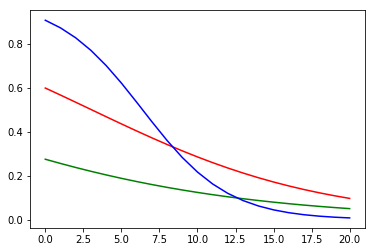

In [130]:
logit_colhomo2_df['prob_fundamentalist'].plot(color='r')
logit_colhomo2_df['prob_moderate'].plot(color='g')
logit_colhomo2_df['prob_liberal'].plot(color='b')